# BTC Price Movement Modeling — From Baseline to Backtest

Este cuaderno documenta, ejecuta y **explica** un pipeline realista para predecir movimientos de BTC usando datos OHLCV por hora.
Incluye: limpieza, features, definición de etiqueta, dos modelos (baseline y v2 orientado a *recall*), métricas de ML y **métricas de trading** con backtest y costos, más una discusión de limitaciones.

> **Input esperado**: un CSV con columnas `['symbol','interval','open_time','open_price','high_price','low_price','close_price','volume','close_time','quote_volume','num_trades','taker_buy_base','taker_buy_quote']`.

## 0. Setup

In [2]:
# Librerías estándar
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ML
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, average_precision_score,
                             precision_recall_curve)
from sklearn.model_selection import TimeSeriesSplit

# Utilidades
import warnings, json
warnings.filterwarnings('ignore')

# Parámetros generales
CSV_PATH = '/Users/guidoboronat/personal/Inversiones - repo/personal_investments/Trading/Precios BTC/precios_btc_2024_1h.csv'  # Cambiar si corresponde
FIGSIZE = (10,5)


## 1. Carga y chequeos mínimos

In [3]:
df = pd.read_csv(CSV_PATH)
df['open_time'] = pd.to_datetime(df['open_time'])
df = df.sort_values('open_time').reset_index(drop=True)
print(df.head(3))
print('\nRango temporal:', df['open_time'].min(), '→', df['open_time'].max())
print('Filas:', len(df))

    symbol interval           open_time  open_price  high_price  low_price  \
0  BTCUSDT       1h 2024-01-01 00:00:00    42581.09    42586.64   42230.08   
1  BTCUSDT       1h 2024-01-01 01:00:00    42330.50    42399.99   42209.46   
2  BTCUSDT       1h 2024-01-01 02:00:00    42399.98    42406.00   42180.77   

   close_price     volume               close_time  quote_volume  num_trades  \
0     42330.49  794.80391  2024-01-01 00:59:59.999  3.370905e+07       38620   
1     42399.99  715.41760  2024-01-01 01:59:59.999  3.027162e+07       36038   
2     42234.01  736.53152  2024-01-01 02:59:59.999  3.115953e+07       32200   

   taker_buy_base  taker_buy_quote  
0       356.37209     1.511300e+07  
1       371.12012     1.570362e+07  
2       340.69312     1.441459e+07  

Rango temporal: 2024-01-01 00:00:00 → 2024-12-31 00:00:00
Filas: 8761


## 2. EDA rápida

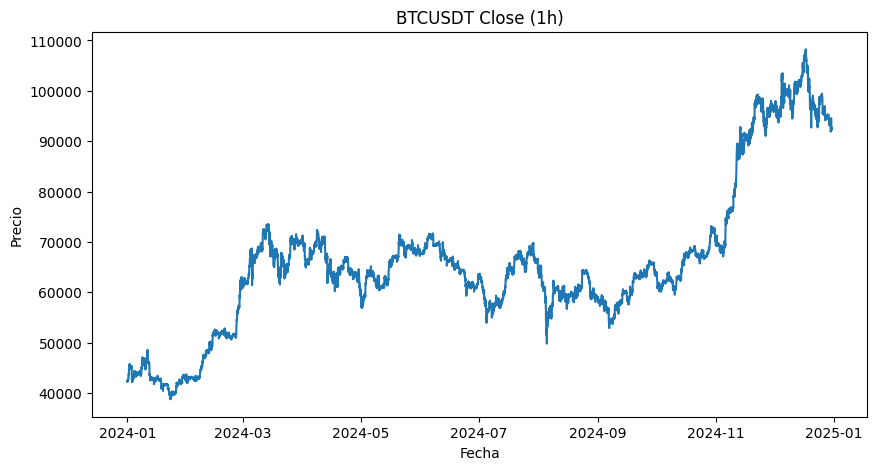

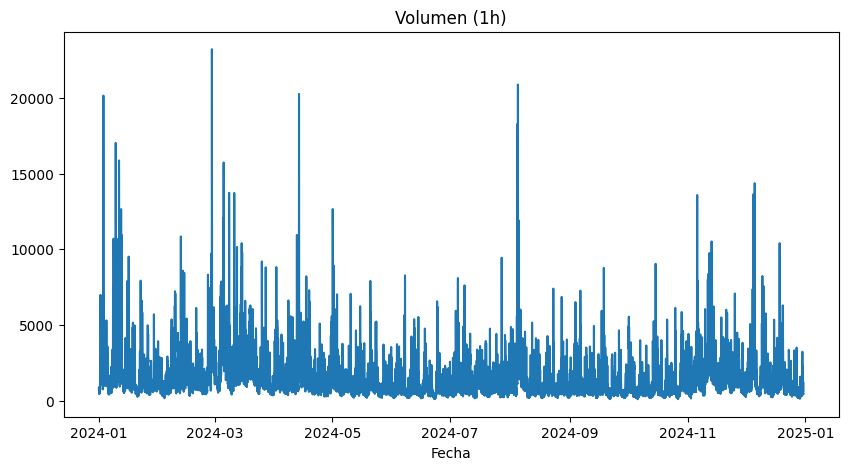

In [4]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(df['open_time'], df['close_price'])
ax.set_title('BTCUSDT Close (1h)')
ax.set_xlabel('Fecha'); ax.set_ylabel('Precio'); plt.show()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(df['open_time'], df['volume'])
ax.set_title('Volumen (1h)'); ax.set_xlabel('Fecha'); plt.show()

## 3. Feature Engineering

In [5]:
def rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    roll_up = pd.Series(gain, index=series.index).rolling(window).mean()
    roll_down = pd.Series(loss, index=series.index).rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line, macd_line - signal_line

def bollinger(series, window=20, num_std=2):
    ma = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    width = (upper - lower) / (ma + 1e-9)
    return ma, upper, lower, width

def add_lags(df, col, lags):
    for l in lags:
        df[f'{col}_lag{l}'] = df[col].shift(l)

In [6]:
# Construcción de features (clásicos + velas + volatilidad)
close = df['close_price']; high = df['high_price']; low = df['low_price']; openp = df['open_price']
vol = df['volume']; trades = df['num_trades']

# Retornos
df['ret_1h'] = close.pct_change()
for w in [3,6,12,24]:
    df[f'ret_{w}h'] = close.pct_change(w)

# Volatilidad
df['vol_12h'] = close.pct_change().rolling(12).std()
df['vol_24h'] = close.pct_change().rolling(24).std()

# MACD, Bollinger, RSI
df['macd'], df['macd_signal'], df['macd_hist'] = macd(close)
df['bb_ma'], df['bb_up'], df['bb_low'], df['bb_width'] = bollinger(close)
df['rsi_14'] = rsi(close, 14)

# Velas
df['hl_range'] = (high - low) / (close.shift(1) + 1e-9)
df['body'] = (close - openp) / (openp + 1e-9)
df['upper_shadow'] = (high - np.maximum(openp, close)) / (openp + 1e-9)
df['lower_shadow'] = (np.minimum(openp, close) - low) / (openp + 1e-9)

# Volumen/actividad
df['vol_chg_1h'] = vol.pct_change()
df['vol_sma_20'] = vol.rolling(20).mean()
df['trades_chg_1h'] = trades.pct_change()

# Lags
for base in ['ret_1h','ret_3h','ret_6h','vol_chg_1h','trades_chg_1h']:
    if base in df.columns:
        add_lags(df, base, [1,2,3])

print('Features creados. NaNs totales:', df.isna().sum().sum())

Features creados. NaNs totales: 259


## 4. Definición de Etiquetas (Targets)

In [7]:
# Target A (baseline): próxima hora sube?
df['future_close_1h'] = close.shift(-1)
df['target_up_1h'] = (df['future_close_1h'] > close).astype(int)

# Target B (v2): sube > +0.3% en próximas 4h
HORIZON_HOURS = 4
PCT_THRESHOLD = 0.003
future_price = close.shift(-HORIZON_HOURS)
df['future_return_4h'] = (future_price - close) / close
df['target_up_4h_03'] = (df['future_return_4h'] > PCT_THRESHOLD).astype(int)

print(df[['target_up_1h','target_up_4h_03']].mean().rename('class_balance'))

target_up_1h       0.511129
target_up_4h_03    0.343682
Name: class_balance, dtype: float64


## 5. Split temporal (80/20)

In [8]:
# Columnas a usar (excluimos metadatos y targets)
exclude = {'symbol','interval','open_time','close_time','future_close_1h','future_return_4h','target_up_1h','target_up_4h_03'}
feature_cols = [c for c in df.columns if c not in exclude]

df_model = df.dropna(subset=feature_cols).reset_index(drop=True)
split_idx = int(len(df_model)*0.8)
print('Train rows:', split_idx, 'Test rows:', len(df_model)-split_idx)

Train rows: 6989 Test rows: 1748


## 6. Modelo Baseline — RandomForest (target_up_1h)

accuracy         0.517735
precision        0.566327
recall           0.361564
f1               0.441352
roc_auc          0.533771
avg_precision    0.553365
dtype: float64


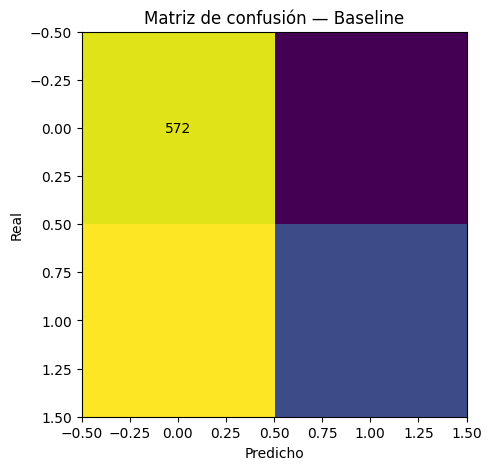

In [9]:
X = df_model[feature_cols].values
y1 = df_model['target_up_1h'].values

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]

rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_prob),
    'avg_precision': average_precision_score(y_test, y_prob)
}
print(pd.Series(metrics))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cm); ax.set_title('Matriz de confusión — Baseline'); ax.set_xlabel('Predicho'); ax.set_ylabel('Real')
for (i,j),v in np.ndenumerate(cm): ax.text(j,i,str(v), ha='center', va='center'); plt.show()

## 7. Modelo v2 — HistGradientBoosting (target_up_4h_03, optimizado a *recall*)

threshold        0.006943
accuracy         0.362128
precision        0.355864
recall           1.000000
f1               0.524925
roc_auc          0.585560
avg_precision    0.424825
dtype: float64


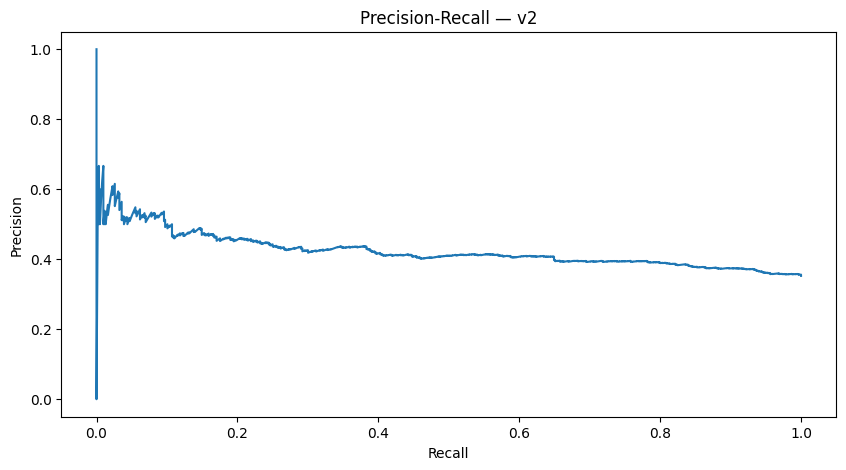

In [10]:
y2 = df_model['target_up_4h_03'].values
y_train2, y_test2 = y2[:split_idx], y2[split_idx:]

hgb = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.06, max_iter=400, random_state=42)
hgb.fit(X_train, y_train2)
y_prob2 = hgb.predict_proba(X_test)[:,1]

# Elegimos umbral que maximiza recall (con desempate por F1)
prec, rec, thr = precision_recall_curve(y_test2, y_prob2)
thr_full = np.r_[0.0, thr]
pr = pd.DataFrame({'threshold': thr_full, 'precision': prec, 'recall': rec})
pr['f1'] = 2*(pr['precision']*pr['recall'])/(pr['precision']+pr['recall']+1e-9)
best = pr.sort_values(['recall','f1','precision'], ascending=[False,False,False]).iloc[0]
THRESHOLD = float(best['threshold'])

y_pred2 = (y_prob2 >= THRESHOLD).astype(int)
metrics2 = {
    'threshold': THRESHOLD,
    'accuracy': accuracy_score(y_test2, y_pred2),
    'precision': precision_score(y_test2, y_pred2, zero_division=0),
    'recall': recall_score(y_test2, y_pred2, zero_division=0),
    'f1': f1_score(y_test2, y_pred2, zero_division=0),
    'roc_auc': roc_auc_score(y_test2, y_prob2),
    'avg_precision': average_precision_score(y_test2, y_prob2)
}
print(pd.Series(metrics2))

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(rec, prec); ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('Precision-Recall — v2'); plt.show()

## 8. Backtest simple (long-only) con costos

Total Return (%)               32.726949
Sharpe                          2.993025
Sortino                         3.977297
Max Drawdown (%)              -15.599755
Win Rate (%)                   52.890173
Profit Factor                   1.098263
Trades (aprox. round-trips)    13.000000
dtype: float64


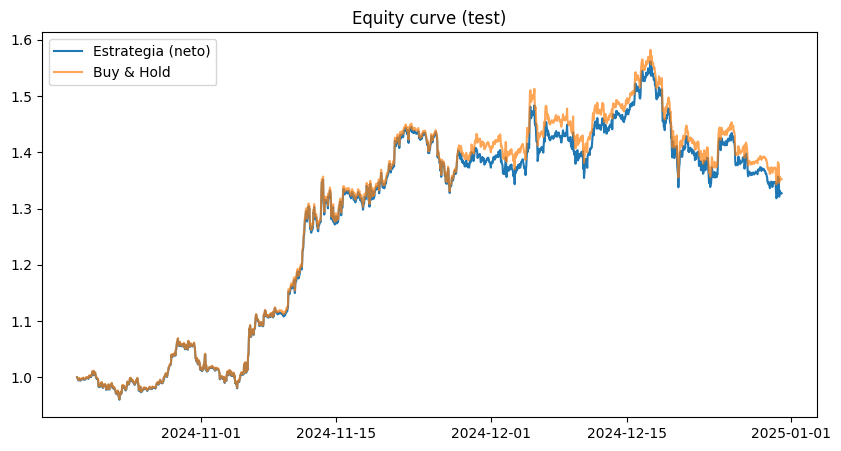

In [11]:
# Señales en test set
subset = df_model.iloc[split_idx:].copy()
subset['signal'] = y_pred2  # 1 = estar largo, 0 = cash

# Retornos horarios reales
subset['ret_real'] = subset['close_price'].pct_change().fillna(0)

# Ejecución al OPEN de la siguiente vela (evitamos look-ahead)
subset['pos'] = subset['signal'].shift(1).fillna(0)

# Costos por cambio de estado (fee por lado)
FEE = 0.001  # 0.10% por lado (ejemplo)
subset['pos_change'] = subset['pos'].diff().fillna(subset['pos'])
trade_cost = FEE * subset['pos_change'].abs()

# Retorno neto
subset['ret_strategy_net'] = subset['ret_real'] * subset['pos'] - trade_cost

subset['equity_strategy_net'] = (1 + subset['ret_strategy_net']).cumprod()
subset['equity_buy_hold'] = (1 + subset['ret_real']).cumprod()

# Métricas de trading
tot_ret = subset['equity_strategy_net'].iloc[-1] - 1
n_trades = int((subset['pos_change'].abs() > 0).sum() // 2)  # aprox. round-trips
win_rate = (subset.loc[subset['pos']==1, 'ret_real'] > 0).mean()
pf = subset.loc[subset['ret_strategy_net']>0,'ret_strategy_net'].sum() / abs(subset.loc[subset['ret_strategy_net']<0,'ret_strategy_net'].sum() + 1e-9)
vol_ann = subset['ret_strategy_net'].std() * np.sqrt(24*365)
sharpe = subset['ret_strategy_net'].mean() / (subset['ret_strategy_net'].std() + 1e-9) * np.sqrt(24*365)
neg_std = subset.loc[subset['ret_strategy_net']<0,'ret_strategy_net'].std()
sortino = subset['ret_strategy_net'].mean() / (neg_std + 1e-9) * np.sqrt(24*365)
roll_max = subset['equity_strategy_net'].cummax()
max_dd = (subset['equity_strategy_net']/roll_max - 1).min()

summary = pd.Series({
    'Total Return (%)': 100*tot_ret,
    'Sharpe': sharpe,
    'Sortino': sortino,
    'Max Drawdown (%)': 100*max_dd,
    'Win Rate (%)': 100*win_rate,
    'Profit Factor': pf,
    'Trades (aprox. round-trips)': n_trades
})
print(summary)

# Gráfico de equity
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(subset['open_time'], subset['equity_strategy_net'], label='Estrategia (neto)')
ax.plot(subset['open_time'], subset['equity_buy_hold'], label='Buy & Hold', alpha=0.7)
ax.set_title('Equity curve (test)'); ax.legend(); plt.show()

## 9. Dónde falla y por qué (discusión)
- **Ruido y baja señal**: retornos horarios tienen mucha varianza; el límite teórico de acierto es bajo.
- **Etiquetas difíciles**: predecir dirección corta (1–4h) es intrínsecamente duro; cambiar horizonte/umbral puede ayudar.
- **Sólo OHLCV**: sin features de microestructura (spread/imbalance), derivados (funding/OI) o sentimiento, el modelo ve poco.
- **Riesgo de sobreajuste**: sin walk‑forward y con tuning agresivo, el backtest puede ser optimista.

**Mitigaciones**: usar walk‑forward, añadir features de Binance (order book, aggTrades, funding, OI), optimizar umbral por métrica de trading, y combinar modelos (GBM + reglas de tendencia/volatilidad).